# YamboConvergence: automated BSE convergence

In the following, we will perform BSE convergence using the same workflow as for the GW simulations: `YamboConvergence`.

In [13]:
from aiida import orm, load_profile
load_profile()

from aiida.plugins import WorkflowFactory
from aiida.orm import QueryBuilder
from aiida.engine import submit

from aiida_quantumespresso.common.types import ElectronicType

import yaml


qb = QueryBuilder()
qb.append(orm.Group, filters={'label': 'Silicon/bulk'}, tag='group')
qb.append(orm.StructureData, with_group='group')

loaded_structure_id = qb.all()[0][0].pk

# Read YAML file
with open("../configuration/codes_localhost.yaml", 'r') as stream:
    codes = yaml.safe_load(stream)
    
with open("../configuration/resources_localhost.yaml", 'r') as stream:
    resources = yaml.safe_load(stream)
    
options = {
    'pseudo_family':"PseudoDojo/0.4/PBE/SR/standard/upf",
    'protocol':'fast',
    #'parent_id':274, #not necessary to set; if you want it, take ytheour previously nscf id (pk) to skip the DFT part.
    'structure_id':loaded_structure_id,
}
options.update(codes)

overrides_scf = {
        'pseudo_family': "PseudoDojo/0.4/PBE/SR/standard/upf", 
        'pw':{
            
        'metadata':{"options":resources},
        },
    }

overrides_nscf = {
        'pseudo_family': "PseudoDojo/0.4/PBE/SR/standard/upf", 
        'pw': {
            'parameters':{
                'CONTROL':{}, #not needed if you don't override something
                'SYSTEM':{},
                'ELECTRONS':{'diagonalization':'cg'},
            },
             'metadata':{"options":resources},
    },
}

overrides_yambo = {
        "yambo": {
            "parameters": {
                "arguments": [
                    "rim_cut",
                ],
                "variables": {
                    "FFTGvecs": [20, "Ry"],
                    'GbndRnge': [[1, 50], ''],
                    'BndsRnXs': [[1, 50], ''],
                    'NGsBlkXs': [2, 'Ry'],
                    'BSENGBlk': [2, 'Ry'],
                    'KfnQP_E':[[1.5,1,1],''],           # <== Scissor and stretching correction.
                    'BS_CPU':'1 1 1',     # <== PARALLELISM INFO
                    'BS_ROLEs':'k eh t',                # <== PARALLELISM INFO
                },
            },
        'metadata':{"options":resources},
        },
    
}

#Be careful with the mesh choice!!! 
overrides_meta = {
        'FFTGvecs': {
            'start_ratio': 0.25,
            'stop_ratio': 0.7,
            'delta_ratio': 0.1,
            'max_ratio': 1,
        },
        'bands': {
            'start': 50,
            'stop': 400,
            'delta': 50,
            'max': 600,
            'ratio':[10,25,50],
        },
        'G_vectors': {
            'start': 2,
            'stop': 8,
            'delta': 1,
            'max': 10,
        },
        'kpoint_density': {
            'start': 1,
            'stop': 0.4,
            'delta': 1,
            'max': 0.1,
        } ,
        'conv_thr_k': 5,   # <== 5% for convergence wrt super-converged estimation.
        'conv_thr_bG': 10,
        'conv_thr_FFT': 10,
        'conv_thr_units': '%', # 'eV'

        
    }

        
overrides_wfl_settings = {
        'what':['lowest_exciton'],          # <== converging the lowest exciton.
        'type': 'heavy', #or cheap; heavy uses converged value for parameters that we are not converging in a given iteration.
    }

overrides = {
        'ywfl':{'scf':overrides_scf,'nscf':overrides_nscf,'yres':overrides_yambo},
        'workflow_settings':overrides_wfl_settings,
    }


YamboConvergence = WorkflowFactory('yambo.yambo.yamboconvergence')
builder = YamboConvergence.get_builder_from_protocol(
    pw_code = options['pwcode_id'],
    preprocessing_code = options['yamboprecode_id'],
    code = options['yambocode_id'],
    protocol=options['protocol'],
    protocol_qe=options['protocol'],
    structure=orm.load_node(options['structure_id']),
    overrides=overrides,
    #parent_folder=load_node(options['parent_id']).outputs.remote_folder,
    electronic_type=ElectronicType.INSULATOR, #default is METAL: smearing is used
    calc_type='bse', #or 'bse'; default is 'gw'
)

builder.ywfl.scf.pw.metadata.options = resources

builder.ywfl.nscf.pw.metadata.options = builder.ywfl.scf.pw.metadata.options
builder.ywfl.yres.yambo.metadata.options = builder.ywfl.scf.pw.metadata.options

Summary of the main inputs:
BndsRnXs = 50
NGsBlkXs = 2 Ry
BSENGBlk = 2 Ry
FFTGvecs = 20 Ry


kpoint mesh for nscf: [6, 6, 6]


/home/max/.conda/envs/aiida/lib/python3.9/site-packages/aiida_quantumespresso/calculations/pw.py:211: UserWarning: `parent_folder` not provided for `nscf` calculation. For work chains wrapping this calculation, you can disable this warning by excluding the `parent_folder` when exposing the inputs of the `PwCalculation`.
  warnings.warn(


In [14]:
try:
    g = orm.load_group('tutorial/Silicon/convergence/BSE')
except:
    g = orm.Group('tutorial/Silicon/convergence/BSE')
    g.store()

In [15]:
builder.group_label = orm.Str('tutorial/Silicon/convergence/BSE') # verdi group create tutorial/Silicon/convergence; all calculationsc are added to the group

In [16]:
builder.ywfl.yres.yambo.parameters = orm.Dict(
    dict={'arguments':['em1s','bse','bss','optics', 'dipoles',],
                'variables':{
                'BSEmod': 'resonant',
                'BSKmod': 'SEX',
                'BSSmod': 'd',
                'Lkind': 'full',
                'NGsBlkXs': [2, 'Ry'],
                'BSENGBlk': [2, 'Ry'],
                'Chimod': 'hartree',
                'DysSolver': 'n',
                'BEnSteps': [10,''],
                'BSEQptR': [[1,1],''],
                'BSEBands': [[4,5],''],
                'BEnRange': [[0.0, 10.0],'eV'],
                'BDmRange': [[0.1, 0.1],'eV'],
                'BLongDir': [[1.0, 1.0, 1.0],''],
                'LongDrXp': [[1.0, 1.0, 1.0],''],
                'LongDrXd': [[1.0, 1.0, 1.0],''],
                'LongDrXs': [[1.0, 1.0, 1.0],''],
                'BndsRnXs': [[1,50], ''],
                'KfnQP_E':[[0.5,1,1],''],
                'BS_CPU':'1 1 1',
                'BS_ROLEs':'k eh t',
                },}
)

In [17]:
builder.parameters_space.get_list()

[{'var': ['FFTGvecs'],
  'start': 9,
  'stop': 25,
  'delta': 3,
  'max': 36,
  'steps': 4,
  'max_iterations': 4,
  'conv_thr': 10,
  'conv_thr_units': '%',
  'convergence_algorithm': 'new_algorithm_1D'},
 {'var': ['kpoint_mesh'],
  'start': [4, 4, 4],
  'stop': [12, 12, 12],
  'delta': [1, 1, 1],
  'max': [22, 22, 22],
  'steps': 4,
  'max_iterations': 4,
  'conv_thr': 10,
  'conv_thr_units': '%',
  'convergence_algorithm': 'new_algorithm_1D'},
 {'var': ['BndsRnXp', 'GbndRnge', 'NGsBlkXp'],
  'start': [200, 200, 6],
  'stop': [800, 800, 18],
  'delta': [100, 100, 2],
  'max': [2000, 2000, 40],
  'steps': 6,
  'max_iterations': 8,
  'conv_thr': 10,
  'conv_thr_units': '%',
  'convergence_algorithm': 'new_algorithm_2D'}]

We will converge only kpoints:

In [18]:
builder.parameters_space = orm.List([{'var': ['kpoint_mesh'],
  'start': [4, 4, 4],
  'stop': [10,10,10],
  'delta': [1, 1, 1],
  'max': [30, 30, 10],
  'steps': 4,
  'max_iterations': 4,
  'conv_thr': 5,
  'conv_thr_units': '%',
  'convergence_algorithm': 'new_algorithm_1D'}])

In [19]:
run = None

In [20]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

/home/max/.conda/envs/aiida/lib/python3.9/site-packages/aiida_quantumespresso/calculations/pw.py:211: UserWarning: `parent_folder` not provided for `nscf` calculation. For work chains wrapping this calculation, you can disable this warning by excluding the `parent_folder` when exposing the inputs of the `PwCalculation`.
  warnings.warn(


uuid: c63328b8-6e20-4256-8861-98205d75ff70 (pk: 1336) (aiida.workflows:yambo.yambo.yamboconvergence)


# Output analysis.

suppose that your calculation completed successfully, then you can access the outputs via the output method of the run instance: 

In [21]:
run.is_finished_ok

False

In [29]:
!verdi process report {run.pk}

2024-02-19 16:44:07 [620 | REPORT]: [1336|YamboConvergence|start_workflow]: group: tutorial/Silicon/convergence/BSE
2024-02-19 16:44:07 [621 | REPORT]: [1336|YamboConvergence|start_workflow]: Workflow type: heavy; looking for convergence of ['lowest_exciton']
2024-02-19 16:44:07 [622 | REPORT]: [1336|YamboConvergence|start_workflow]: Workflow initilization step completed, the parameters will be: ['kpoint_mesh'].
2024-02-19 16:44:07 [623 | REPORT]: [1336|YamboConvergence|has_to_continue]: Still iteration on ['kpoint_mesh']
2024-02-19 16:44:07 [624 | REPORT]: [1336|YamboConvergence|pre_needed]: {'kpoint_mesh': [[4, 4, 4], [6, 6, 6], [8, 8, 8], [10, 10, 10]]}
2024-02-19 16:44:08 [625 | REPORT]: [1336|YamboConvergence|next_step]: New parameters are: {'kpoint_mesh': [4, 4, 4]}
2024-02-19 16:44:11 [626 | REPORT]: [1336|YamboConvergence|next_step]: New parameters are: {'kpoint_mesh': [6, 6, 6]}
2024-02-19 16:44:15 [627 | REPORT]: [1336|YamboConvergence|next_step]: New parameters are: {'kpoint

The converged parameters can be obtained via the "infos" output Dict:

In [30]:
run.outputs.infos.get_dict()

{'E_ref': 2.9750659078219,
 'kpoint_mesh': [4, 4, 4],
 'lowest_exciton': 2.9639761447906}

The full convergence history can be visualized in a table form using pandas:

In [31]:
import pandas as pd

In [32]:
history = run.outputs.history.get_dict()

In [33]:
history_table = pd.DataFrame(history)

In [34]:
history_table

,uuid,failed,useful,global_step,kpoint_mesh,lowest_exciton,parameters_studied
0,370fe54f-1e58-48fd-8d67-5edd3ba1e863,False,True,1,"[4, 4, 4]",2.963976,kpoint_mesh
1,f02c018f-7e0c-452f-8f09-fde92dc9f966,False,False,2,"[6, 6, 6]",2.953815,kpoint_mesh
2,175085a4-8dfe-484f-93e7-75c402337e59,False,False,3,"[8, 8, 8]",2.965224,kpoint_mesh
3,713880e5-40fc-4bc9-a51b-173876953799,False,False,4,"[10, 10, 10]",2.978290,kpoint_mesh


The last calculations can be obtained using:

In [35]:
history_table[history_table['useful']==True]

,uuid,failed,useful,global_step,kpoint_mesh,lowest_exciton,parameters_studied
0,370fe54f-1e58-48fd-8d67-5edd3ba1e863,False,True,1,"[4, 4, 4]",2.963976,kpoint_mesh


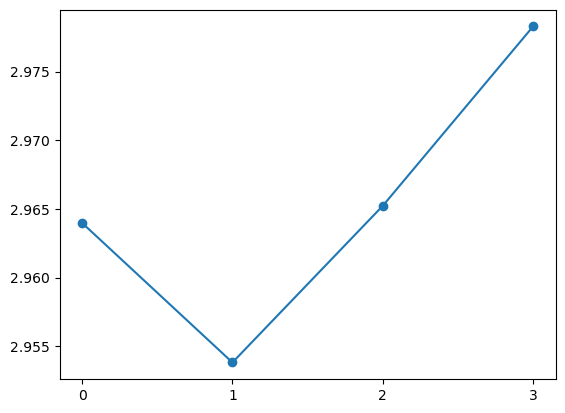

In [39]:
import matplotlib.pyplot as plt

k_history = history_table[history_table['parameters_studied']=="kpoint_mesh"]

plt.plot(k_history.lowest_exciton,'o-')

## Exercise 1: try to compute BSE convergence but using QP instead of scissor and stretching.

Solution provided in the `Solution_2_YamboConvergence_BSE_QP.ipynb` notebook. 
Please look at the `6_1_YamboWorkflow_BSE_QP.ipynb` to understand how to set the preliminary QP calculation.

## Exercise 2: computing the convergence not with respect to the k-mesh, but with respect to the k-point density.

Solution provided in the `Solution_3_YamboConvergence_BSE_k_density.ipynb` notebook.

```python
builder.parameters_space = orm.List(list=[
 {'var': ['kpoint_density'],
  'start': 1/0.05,
  'stop': 1/0.025,
  'delta': 1,      #1/0.01
  'max': 1/0.02,
  'steps': 4,
  'max_iterations': 4,
  'conv_thr': 3,
  'conv_thr_units': '%',
  'convergence_algorithm': 'new_algorithm_1D'},])
```